# Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.io
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

# Loading Data

In [2]:
data = np.loadtxt("data.txt")
data_label = np.argmax(data[:,27:34],-1)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data[:,0:27])
data_scaler = scaler.transform(data[:,0:27])
data_new = np.concatenate((np.expand_dims(data_label,axis=1), data_scaler), axis = 1)
train, test = train_test_split(data_new, stratify = data_label, test_size = 0.2)
dim = train.shape[1]

# Distinguish the train/test and normal/abnormal

In [3]:
X_normal_train = train[train[:,0] == 0,1:dim]
Y_normal_train = train[train[:,0] == 0,0]

X_normal_test = test[test[:,0] == 0,1:dim]
Y_normal_test = test[test[:,0] == 0,0]

X_abnormal_train = train[train[:,0] == 1,1:dim]
Y_abnormal_train = train[train[:,0] == 1,0]

X_abnormal_test = test[test[:,0] == 1,1:dim]
Y_abnormal_test = test[test[:,0] == 1,0]

X_transition_train = train[train[:,0] == 5,1:dim]
Y_transition_train = (train[train[:,0] == 5,0]+1)/3

X_transition_test = test[test[:,0] == 5,1:dim]
Y_transition_test = (test[test[:,0] == 5,0]+1)/3
# 126,152,321

Org data dimension is 27. Embedded data dimension is 2


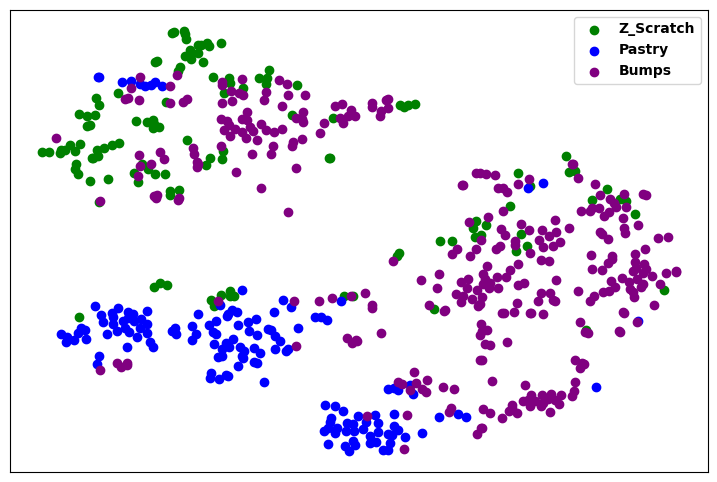

In [20]:
X_train_all = np.concatenate((X_normal_train,X_abnormal_train,X_transition_train))
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold,datasets

tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(np.squeeze(X_train_all))
print("Org data dimension is {}. Embedded data dimension is {}".format(np.squeeze(X_train_all).shape[-1], X_tsne.shape[-1]))

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(9, 6))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.scatter(X_norm[0:126, 0], X_norm[0:126, 1],color = 'green', label = "Z_Scratch")
plt.scatter(X_norm[126:278, 0], X_norm[126:278, 1],color = 'blue', label = "Pastry")
plt.scatter(X_norm[278:599, 0], X_norm[278:599, 1],color = 'purple', label = "Bumps")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

# Baseline

## Distinguish the type 1,2 and 3

In [5]:
X_teacher1 = np.concatenate((X_normal_train,X_abnormal_train))
Y_teacher1 = np.concatenate((np.expand_dims(Y_normal_train, axis = 1), np.expand_dims(Y_abnormal_train, axis = 1)), axis = 0)
Y_teacher1 = Y_teacher1.reshape(-1)
Y_train1 = Y_teacher1 + 0

X_test1 = np.concatenate((X_normal_test, X_abnormal_test))
Y_test_teacher1 = np.concatenate((np.expand_dims(Y_normal_test, axis = 1), np.expand_dims(Y_abnormal_test, axis = 1)), axis = 0)
Y_test_teacher1 = Y_test_teacher1.reshape(-1)
Y_test1 = Y_test_teacher1 + 0

In [6]:
X_teacher2 = np.concatenate((X_normal_train,X_transition_train))
Y_teacher2 = np.concatenate((np.expand_dims(Y_normal_train, axis = 1), np.expand_dims(Y_transition_train, axis = 1)), axis = 0)
Y_teacher2 = Y_teacher2.reshape(-1)
Y_train2 = Y_teacher2 + 0

X_test2 = np.concatenate((X_normal_test, X_transition_test))
Y_test_teacher2 = np.concatenate((np.expand_dims(Y_normal_test, axis = 1), np.expand_dims(Y_transition_test, axis = 1)), axis = 0)
Y_test_teacher2 = Y_test_teacher2.reshape(-1)
Y_test2 = Y_test_teacher2 + 0

In [7]:
X_teacher3 = np.concatenate((X_normal_train,X_abnormal_train,X_transition_train))
Y_teacher3 = np.concatenate((np.expand_dims(Y_normal_train, axis = 1), np.expand_dims(Y_abnormal_train, axis = 1),np.expand_dims(Y_transition_train, axis = 1)), axis = 0)
Y_teacher3 = Y_teacher3.reshape(-1)
Y_train3 = Y_teacher3 + 0

X_test3 = np.concatenate((X_normal_test, X_abnormal_test,X_transition_test))
Y_test_teacher3 = np.concatenate((np.expand_dims(Y_normal_test, axis = 1), np.expand_dims(Y_abnormal_test, axis = 1),np.expand_dims(Y_transition_test, axis = 1)), axis = 0)
Y_test_teacher3 = Y_test_teacher3.reshape(-1)
Y_test3 = Y_test_teacher3 + 0

## Do the classification

### Type 1 and type 2 classification

In [10]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

model = Sequential()
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='best_model.keras',  # File to save the best model
                             monitor='val_loss',  # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             save_weights_only=False,  # Save the entire model (including architecture)
                             mode='min',  # Mode can be 'min' for loss or 'max' for accuracy
                             verbose=1)

# Train the model
epochs = 30
batch_size = 32
history  = model.fit(X_teacher1, Y_train1, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test1, Y_test1), callbacks=[checkpoint])

print(model.summary())
val_acc = history.history['val_accuracy']

#%% Evaluate the model
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

predicted_labels = model.predict(X_test1)
y_pred = np.argmax(predicted_labels, axis = 1).astype(int)
#y_pred = (predicted_labels >= .5).astype(int)

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test_teacher1, y_pred)

# Compute precision, recall, and F1-score
classification_rep = classification_report(Y_test_teacher1, y_pred)
del model
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)

Epoch 1/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5625 - loss: 0.8361
Epoch 1: val_loss improved from inf to 0.62155, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.6319 - loss: 0.8232 - val_accuracy: 0.8286 - val_loss: 0.6216
Epoch 2/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.6562 - loss: 0.8168
Epoch 2: val_loss improved from 0.62155 to 0.50391, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7514 - loss: 0.7005 - val_accuracy: 0.8857 - val_loss: 0.5039
Epoch 3/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.6562 - loss: 0.6296
Epoch 3: val_loss improved from 0.50391 to 0.40688, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8234 - loss: 0.5623 - val_accuracy: 0.9429 - val_loss: 0.4069
Epoch 4/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7500 - loss: 0.5478
Epoch 4: val_loss improved from 0.40688 to 0.33315, saving model to best_m

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 24)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              39 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,035 (11.86 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,024 (7.91 KB)

None
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Confusion Matrix:
[[31  1]
 [ 0 38]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        32
         1.0       0.97      1.00      0.99        38

    accuracy                           0.99        70
   macro avg       0.99      0.98      0.99        70
weighted avg       0.99      0.99      0.99        70



### Type 1,2, and 3 increment classification

In [13]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='best_model.keras',  # File to save the best model
                             monitor='val_loss',  # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             save_weights_only=False,  # Save the entire model (including architecture)
                             mode='min',  # Mode can be 'min' for loss or 'max' for accuracy
                             verbose=1)

# Train the model
epochs = 30
batch_size = 32
history  = model.fit(X_teacher2, Y_train2, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test3, Y_test3), callbacks=[checkpoint])

print(model.summary())

#%% Evaluate the model
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

predicted_labels = model.predict(X_test3)
y_pred = np.argmax(predicted_labels, axis = 1).astype(int)
#y_pred = (predicted_labels >= .5).astype(int)

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test_teacher3, y_pred)

# Compute precision, recall, and F1-score
classification_rep = classification_report(Y_test_teacher3, y_pred)
del model
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)

Epoch 1/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8750 - loss: 0.4176
Epoch 1: val_loss improved from inf to 0.71479, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8464 - loss: 0.4244 - val_accuracy: 0.7285 - val_loss: 0.7148
Epoch 2/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.8750 - loss: 0.3612
Epoch 2: val_loss did not improve from 0.71479
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8364 - loss: 0.4012 - val_accuracy: 0.7219 - val_loss: 0.7700
Epoch 3/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8750 - loss: 0.3069
Epoch 3: val_loss did not improve from 0.71479
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8720 - loss: 0.3232 - val_accuracy: 0.7020 - val_loss: 0.8306
Epoch 4/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step - accuracy: 0.8750 - loss: 0.2823
Epoch 4: val_loss did not improve from 0.71479
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8724 - loss: 0.3274 - val_accuracy: 0.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 24)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │              39 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,035 (11.86 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,024 (7.91 KB)

None


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix:
[[21  0 11]
 [ 1 12 25]
 [ 4  0 77]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.66      0.72        32
         1.0       1.00      0.32      0.48        38
         2.0       0.68      0.95      0.79        81

    accuracy                           0.73       151
   macro avg       0.83      0.64      0.67       151
weighted avg       0.79      0.73      0.70       151



### Type 1,2 and 3 classification

In [ ]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

model = Sequential()
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='best_model.h5',  # File to save the best model
                             monitor='val_loss',  # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             save_weights_only=False,  # Save the entire model (including architecture)
                             mode='minx',  # Mode can be 'min' for loss or 'max' for accuracy
                             verbose=1)

# Train the model
epochs = 30
batch_size = 32
history  = model.fit(X_teacher3, Y_train3, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test3, Y_test3), callbacks=[checkpoint])

print(model.summary())
val_acc = history.history['val_accuracy']

#%% Evaluate the model
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

predicted_labels = model.predict(X_test3)
y_pred = np.argmax(predicted_labels, axis = 1).astype(int)
#y_pred = (predicted_labels >= .5).astype(int)

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test_teacher3, y_pred)

# Compute precision, recall, and F1-score
classification_rep = classification_report(Y_test_teacher3, y_pred)
del model
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)

Epoch 1/30
 1/19 [>.............................] - ETA: 14s - loss: 0.8525 - accuracy: 0.6250
Epoch 1: val_loss improved from inf to 0.90377, saving model to best_model_s2.h5
19/19 [==============================] - 1s 14ms/step - loss: 0.9965 - accuracy: 0.5209 - val_loss: 0.9038 - val_accuracy: 0.5430
Epoch 2/30
 1/19 [>.............................] - ETA: 0s - loss: 0.9067 - accuracy: 0.6562
Epoch 2: val_loss improved from 0.90377 to 0.83070, saving model to best_model_s2.h5
19/19 [==============================] - 0s 6ms/step - loss: 0.9049 - accuracy: 0.5459 - val_loss: 0.8307 - val_accuracy: 0.5695
Epoch 3/30
 1/19 [>.............................] - ETA: 0s - loss: 0.9039 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 0.83070 to 0.77142, saving model to best_model_s2.h5
19/19 [==============================] - 0s 6ms/step - loss: 0.8401 - accuracy: 0.5776 - val_loss: 0.7714 - val_accuracy: 0.6225
Epoch 4/30
 1/19 [>.............................] - ETA: 0s - loss: 0.8194 - accuracy: 0.6250
Epoch 4: val_loss improved from 0.77142 to 0.72472, saving model to best_model_s2.h5
19/19 [==============================] - 0s 5ms/step - loss: 0.7834 - accuracy: 0.6477 - val_loss: 0.7247 - val_accuracy: 0.7219
Epoch 5/30
 1/19 [>.............................] - ETA: 0s - loss: 0.8809 - accuracy: 0.5312
Epoch 5: val_loss improved from 0.72472 to 0.66956, saving model to best_model_s2.h5
19/19 [==============================] - 0s 6ms/step - loss: 0.7321 - accuracy: 0.7262 - val_loss: 0.6696 - val_accuracy: 0.7748
Epoch 6/30
 1/19 [>.............................] - ETA: 0s - loss: 0.6384 - accuracy: 0.7500
Epoch 6: val_loss improved from 0.66956 to 0.61818, saving model to best_mo

# RCL

## Generate the initial data for training

In [16]:
num_abnormal_train = X_abnormal_train.shape[0]
num_normal_train = X_normal_train.shape[0]

import SMOTE
# SMOTE for abnormal
s1 = SMOTE.Smote(X_abnormal_train,N = 100)
newdata_smote1 = np.unique(s1.over_sampling(),axis = 0)

# SMOTE for normal
s2 = SMOTE.Smote(X_normal_train,N = 100)
newdata_smote2 = np.unique(s2.over_sampling(),axis = 0)

# SMOTE for transition
s3 = SMOTE.Smote(X_transition_train,N = 100)
newdata_smote3 = np.unique(s3.over_sampling(),axis = 0)

X_abnormal_train_new = newdata_smote1 + 0.0
X_normal_train_new = newdata_smote2 + 0.0
X_transition_train_new = newdata_smote3 + 0.0

## Distinguish the type 1,2 and 3

In [23]:
X_teacher1 = np.concatenate((X_normal_train_new,X_abnormal_train))
Y_teacher1 = np.concatenate((np.expand_dims(Y_normal_train, axis = 1), np.expand_dims(Y_abnormal_train, axis = 1)), axis = 0)
Y_teacher1 = Y_teacher1.reshape(-1)
Y_train1 = Y_teacher1 + 0

X_test1 = np.concatenate((X_normal_test, X_abnormal_test))
Y_test_teacher1 = np.concatenate((np.expand_dims(Y_normal_test, axis = 1), np.expand_dims(Y_abnormal_test, axis = 1)), axis = 0)
Y_test_teacher1 = Y_test_teacher1.reshape(-1)
Y_test1 = Y_test_teacher1 + 0

X_teacher2 = np.concatenate((X_normal_train_new,X_transition_train))
Y_teacher2 = np.concatenate((np.expand_dims(Y_normal_train, axis = 1), np.expand_dims(Y_transition_train, axis = 1)), axis = 0)
Y_teacher2 = Y_teacher2.reshape(-1)
Y_train2 = Y_teacher2 + 0

X_test2 = np.concatenate((X_normal_test, X_transition_test))
Y_test_teacher2 = np.concatenate((np.expand_dims(Y_normal_test, axis = 1), np.expand_dims(Y_transition_test, axis = 1)), axis = 0)
Y_test_teacher2 = Y_test_teacher2.reshape(-1)
Y_test2 = Y_test_teacher2 + 0

X_teacher3 = np.concatenate((X_normal_train_new,X_abnormal_train_new,X_transition_train))

Y_teacher3 = np.concatenate((np.expand_dims(Y_normal_train, axis = 1), np.expand_dims(Y_abnormal_train, axis = 1),np.expand_dims(Y_transition_train, axis = 1)), axis = 0)
Y_teacher3 = Y_teacher3.reshape(-1)
Y_train3 = Y_teacher3 + 0

X_test3 = np.concatenate((X_normal_test, X_abnormal_test,X_transition_test))
Y_test_teacher3 = np.concatenate((np.expand_dims(Y_normal_test, axis = 1), np.expand_dims(Y_abnormal_test, axis = 1),np.expand_dims(Y_transition_test, axis = 1)), axis = 0)
Y_test_teacher3 = Y_test_teacher3.reshape(-1)
Y_test3 = Y_test_teacher3 + 0


## Do the classification

In [24]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

model = Sequential()
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='best_model2.keras',  # File to save the best model
                             monitor='val_loss',  # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             save_weights_only=False,  # Save the entire model (including architecture)
                             mode='min',  # Mode can be 'min' for loss or 'max' for accuracy
                             verbose=1)

# Train the model
epochs = 30
batch_size = 32
history  = model.fit(X_teacher1, Y_train1, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test1, Y_test1), callbacks=[checkpoint])

print(model.summary())
val_acc = history.history['val_accuracy']

#%% Evaluate the model
from tensorflow.keras.models import load_model
model = load_model('best_model2.keras')

predicted_labels = model.predict(X_test1)
y_pred = np.argmax(predicted_labels, axis = 1).astype(int)
#y_pred = (predicted_labels >= .5).astype(int)

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test_teacher1, y_pred)

# Compute precision, recall, and F1-score
classification_rep = classification_report(Y_test_teacher1, y_pred)
del model
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)

Epoch 1/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3125 - loss: 1.5884
Epoch 1: val_loss improved from inf to 1.08649, saving model to best_model2.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4942 - loss: 1.2542 - val_accuracy: 0.5286 - val_loss: 1.0865
Epoch 2/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5000 - loss: 1.0865
Epoch 2: val_loss improved from 1.08649 to 0.94952, saving model to best_model2.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5478 - loss: 1.0491 - val_accuracy: 0.5429 - val_loss: 0.9495
Epoch 3/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5312 - loss: 0.9277
Epoch 3: val_loss improved from 0.94952 to 0.82651, saving model to best_model2.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6013 - loss: 0.8962 - val_accuracy: 0.5857 - val_loss: 0.8265
Epoch 4/30
1/9 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6562 - loss: 0.7752
Epoch 4: val_loss improved from 0.82651 to 0.70225, saving model to bes

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 24)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │              39 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,035 (11.86 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,024 (7.91 KB)

None
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Confusion Matrix:
[[31  1]
 [ 0 38]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        32
         1.0       0.97      1.00      0.99        38

    accuracy                           0.99        70
   macro avg       0.99      0.98      0.99        70
weighted avg       0.99      0.99      0.99        70



In [25]:
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
#    from keras.layers.normalization import LayerNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import load_model
model = load_model('best_model2.keras')

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath='best_model2.keras',  # File to save the best model
                             monitor='val_loss',  # Monitor validation loss
                             save_best_only=True,  # Save only the best model
                             save_weights_only=False,  # Save the entire model (including architecture)
                             mode='min',  # Mode can be 'min' for loss or 'max' for accuracy
                             verbose=1)

# Train the model
epochs = 30
batch_size = 32
history  = model.fit(X_teacher2, Y_train2, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test3, Y_test3), callbacks=[checkpoint])

print(model.summary())

#%% Evaluate the model
from tensorflow.keras.models import load_model
model = load_model('best_model2.keras')

predicted_labels = model.predict(X_test3)
y_pred = np.argmax(predicted_labels, axis = 1).astype(int)
#y_pred = (predicted_labels >= .5).astype(int)

# Compute the confusion matrix
confusion_mat = confusion_matrix(Y_test_teacher3, y_pred)

# Compute precision, recall, and F1-score
classification_rep = classification_report(Y_test_teacher3, y_pred)
del model
# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_rep)

Epoch 1/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 10s 795ms/step - accuracy: 0.2500 - loss: 2.9159
Epoch 1: val_loss improved from inf to 1.13046, saving model to best_model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2701 - loss: 2.6300 - val_accuracy: 0.4503 - val_loss: 1.1305
Epoch 2/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3125 - loss: 1.4836
Epoch 2: val_loss improved from 1.13046 to 0.57452, saving model to best_model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3497 - loss: 1.3102 - val_accuracy: 0.7616 - val_loss: 0.5745
Epoch 3/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5625 - loss: 0.8593
Epoch 3: val_loss improved from 0.57452 to 0.50611, saving model to best_model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6461 - loss: 0.7104 - val_accuracy: 0.7815 - val_loss: 0.5061
Epoch 4/30
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.8438 - loss: 0.4425
Epoch 4: val_loss did not improve from 0.50611
14/14 ━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 24)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 12)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │              39 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,035 (11.86 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,024 (7.91 KB)

None
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix:
[[21  0 11]
 [ 1 28  9]
 [ 4  8 69]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.66      0.72        32
         1.0       0.78      0.74      0.76        38
         2.0       0.78      0.85      0.81        81

    accuracy                           0.78       151
   macro avg       0.79      0.75      0.76       151
weighted avg       0.78      0.78      0.78       151

